<a href="https://colab.research.google.com/github/Dicere/WB_Internship/blob/main/0_9_testing_another_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install lazypredict
!pip install lightgbm
!pip install xgboost

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier,Pool
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, recall_score, precision_recall_curve,precision_score, precision_recall_fscore_support
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WB_стажировка/wb_school_task_2.csv.gzip',compression='gzip')
df = df.drop_duplicates(ignore_index=True)
df_id3 = pd.read_csv('/content/drive/MyDrive/WB_стажировка/MAIN/db_agg_by_id3.csv')

In [ ]:
kvad_sum=(lambda x: sum(i**2 for i in x))
kvad_sum.__name__ = 'kvad_sum'

interkvartil_razmah = (lambda x: np.percentile(x, 75) - np.percentile(x, 25))
interkvartil_razmah.__name__ = 'interkvartil_razmah'

range_dannih = (lambda x: x.max()-x.min())
range_dannih.__name__ = 'range_dannih'

quant90 = lambda x: x.quantile(0.9)
quant90.__name__ = 'quant90'

In [ ]:
aggs_list = ['min','max', 'mean', 'median', 'count', 'sum',kvad_sum,interkvartil_razmah,range_dannih,quant90]

In [ ]:
df_agg = df[['id3','f1','f2','f3','f4','f5','f6','f7','f8']].groupby(by=['id3']).agg(aggs_list).reset_index()
df_agg.columns = ['_by_id3_'.join(col) for col in df_agg.columns.values]
df_agg = df_agg.rename(columns={'id3_by_id3_':'id3'})

In [ ]:
df1 = pd.merge(df,df_agg,how='left',on=['id3'])

In [ ]:
clear_df = df1[['f1','f2','f3','f4','f5','f6','f7','f8','f1_by_id3_sum', 'f2_by_id3_sum', 'f3_by_id3_sum', 'f4_by_id3_sum',
       'f5_by_id3_sum', 'f6_by_id3_sum', 'f7_by_id3_sum', 'f8_by_id3_sum']]

In [ ]:
feature_dict = {}
def summ(b=0,i=0):
  name = str('sum_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
  feature_dict[name] = clear_df.iloc[:,b] + clear_df.iloc[:,i]
def subtraction(b=0,i=0):
    name = str('subtraction_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] - clear_df.iloc[:,i])
def multiplication(b=0,i=0):
    name = str('multiplication_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] * clear_df.iloc[:,i])
def division(b=0,i=0):
    name = str('division_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs((clear_df.iloc[:,b] / clear_df.iloc[:,i]).fillna(0))
    name = str('division_'+clear_df.columns[i]+"_"+clear_df.columns[b])
    feature_dict[name] = abs((clear_df.iloc[:,i] /clear_df.iloc[:,b]).fillna(0))

In [ ]:
conversions_list = {'sum':summ,'subtraction':subtraction,'division':division,'multiplication':multiplication}

In [ ]:
idx=0
for conv in conversions_list.keys():
  for b in range(len(clear_df.columns)-1):
    if conv == 'multiplication':
      for i in range(b,len(clear_df.columns)):
        conversions_list[conv](b,i)
    else:
      for i in range(b+1,len(clear_df.columns)):
        conversions_list[conv](b,i)


In [ ]:
df1 = df1.assign(**feature_dict)

In [ ]:
cols_to_drop = df1.columns[df1.nunique() == 1]
df1 = df1.drop(cols_to_drop, axis=1)
df1.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
X = df1[df1.drop('label', axis=1).columns[4::]]
y=df1.label

In [ ]:
N_SPLITS = 7
current_feat = list(X.columns[:8])
best_threshold_all = 0

In [ ]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_mean', 'sum_f3_f6', 'division_f1_f2', 'division_f4_f7', 'division_f7_f5', 'division_f7_f8', 'multiplication_f3_f3']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
def predict_precsion_recall(y_test, pred):
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  return [precision, recall]

In [ ]:
# clf = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=predict_precsion_recall)
# models, predictions = clf.fit(X_train[current_feat], X_test[current_feat], y_train, y_test)
# models[['Precision', 'Recall']] = models['predict_precsion_recall'].apply(lambda x: pd.Series(x))
# models.drop(columns=['predict_precsion_recall'],inplace=True)
# models.sort_values(by='F1 Score', ascending=False,inplace=True)
# models

In [ ]:
# clf = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=predict_precsion_recall)
# models, predictions = clf.fit(X_train[columns], X_test[columns], y_train, y_test)
# models[['Precision', 'Recall']] = models['predict_precsion_recall'].apply(lambda x: pd.Series(x))
# models.drop(columns=['predict_precsion_recall'],inplace=True)
# models.sort_values(by='F1 Score', ascending=False,inplace=True)
# models

In [ ]:
def f1(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = (y_pred> 0.5).astype('int')
    # y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true.astype(int))
    f1 = f1_score(y_true, y_pred,average='macro')
    return "f1",f1,True

In [ ]:
def calc_log_loss_weight(y_true):
    y_true = y_true.astype(int)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1

In [ ]:
def plot(scores,best_score,text):
  plt.figure(figsize=(20,5))
  plt.plot(thresholds,scores,'-o',color='blue')
  plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
  plt.xlabel('Threshold',size=14)
  plt.ylabel(f'Validation {i}',size=14)
  plt.title(f'Threshold vs. {i} with Best {i}= {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
  plt.show()

### lgbm с весами

In [ ]:
eval_result={}
threshold = 0.5
params={
    'learning_rate': 0.05,
    "metric": "None",
    "num_iterations": 1000,
    "first_metric_only": True,
    "verbose": 1,
    "num_leaves": 4,
        }
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=22)
cv_scores_AUC_ROC = np.empty(N_SPLITS)
cv_scores_f1_score = np.empty(N_SPLITS)
cv_scores_Precision = np.empty(N_SPLITS)
cv_scores_Recall = np.empty(N_SPLITS)
cv_scores = np.empty(N_SPLITS)
roc_auc_score_1 = np.empty(N_SPLITS)
models_lgbm=[]
indx_all = X_train.index
oof = pd.DataFrame(data=np.zeros((len(indx_all),1)), index=indx_all)
for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
  # print('--'*10+f'TRIAL {trial.number} ~ '+f'FOLD {idx}'+'--'*10)
  X_train_сv, X_val_сv = X_train[columns].iloc[train_idx], X_train[columns].iloc[test_idx]
  y_train_сv, y_val_сv = y_train.iloc[train_idx], y_train.iloc[test_idx]

  train_w0, train_w1 = calc_log_loss_weight(y_train_сv)
  valid_w0, valid_w1 = calc_log_loss_weight(y_val_сv)

  d_train = lgb.Dataset(data = X_train_сv.values,weight=y_train_сv.map({0: train_w0, 1: train_w1}), label = y_train_сv.values)
  d_val = lgb.Dataset(data = X_val_сv.values,weight=y_val_сv.map({0: valid_w0, 1: valid_w1}), label = y_val_сv.values)

  # TRAIN MODEL
  clf =  lgb.LGBMClassifier()

  early = lgb.early_stopping(50, first_metric_only=False, verbose=True)
  record_eval = lgb.record_evaluation(eval_result)
  model = lgb.train(params,
                  train_set=d_train,
                  valid_sets=[d_val],
                  feval=f1,
                  callbacks=[early,record_eval])
  models_lgbm.append(model)
  y_pred = model.predict(X_val_сv)
  oof.loc[X_val_сv.index,0] = y_pred
  y_pred_metki = (y_pred> 0.5).astype('int')
  precision = precision_score(y_val_сv, y_pred_metki)
  recall = recall_score(y_val_сv, y_pred_metki)
  cv_scores_AUC_ROC[idx] = roc_auc_score(y_val_сv, y_pred)
  cv_scores_f1_score[idx] = f1_score(y_val_сv, y_pred_metki,average='macro')
  # print(precision)
  cv_scores_Precision[idx] = precision
  cv_scores_Recall[idx] = recall

print("AUC_ROC----"+str(np.mean(cv_scores_AUC_ROC)))
print("F1-score-----"+str(np.mean(cv_scores_f1_score)))
print("Precision-----"+str(np.mean(cv_scores_Precision)))
print("Recall-----"+str(np.mean(cv_scores_Recall)))

0.05, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.22, 0.22

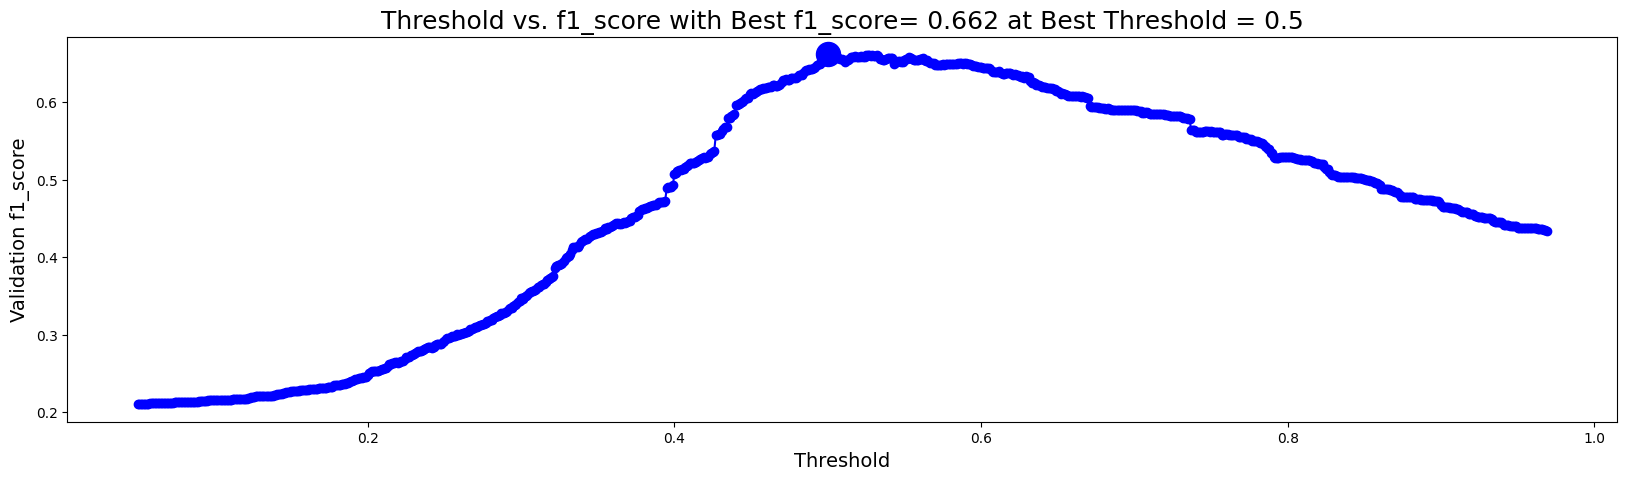

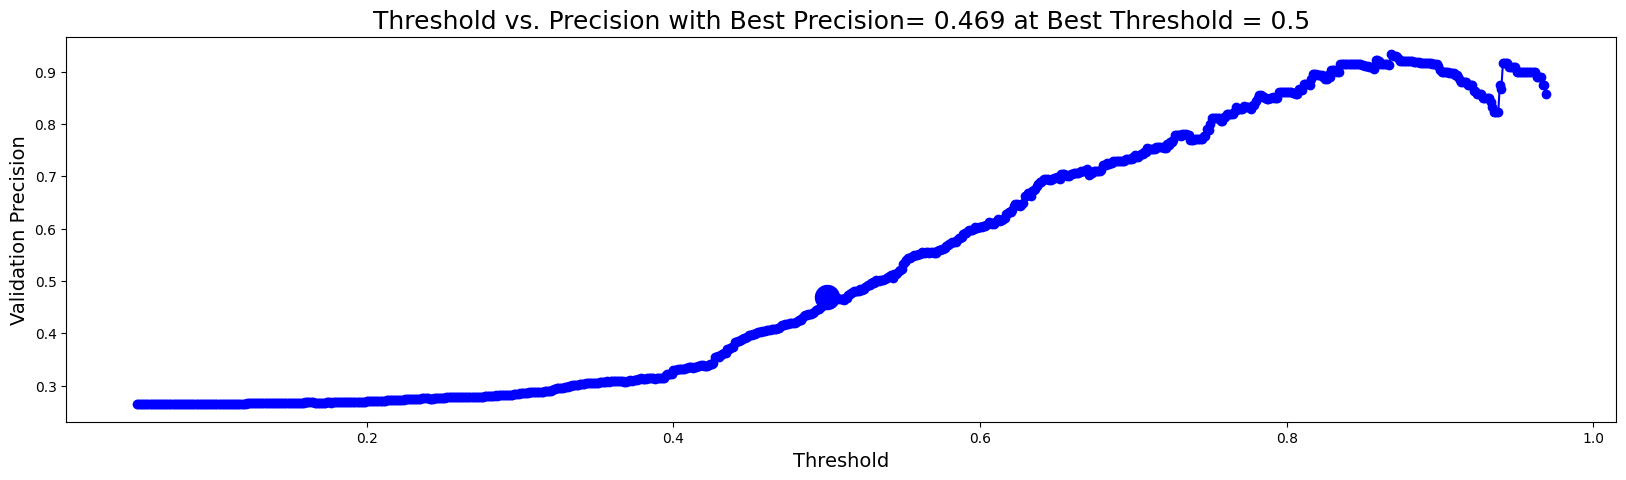

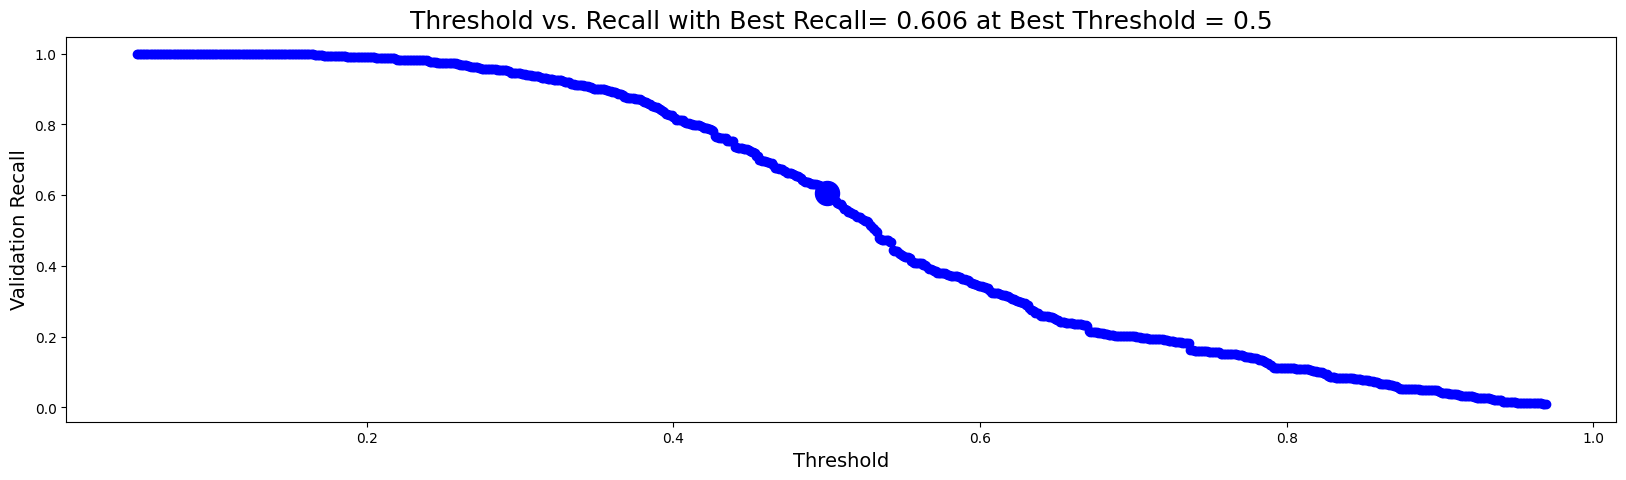

In [ ]:
scores_f1_score=[]
scores_Precision=[]
scores_Recall=[]
scores = []; thresholds = []
best_f1= 0;best_score_pr= 0;best_score_rc = 0; best_threshold = 0
true = y_train

for threshold in np.arange(0.05,0.97,0.001):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    # scores.append(m)
    pr = precision_score(true.values.reshape((-1)), preds)
    rc = recall_score(true.values.reshape((-1)), preds)
    f1 = f1_score(true.values.reshape((-1)), preds,average='macro')
    m= f1_score(true.values.reshape((-1)), preds,average='macro')
    scores_f1_score.append(f1)
    scores_Precision.append(pr)
    scores_Recall.append(rc)
    thresholds.append(threshold)
    if m>best_f1:
        best_f1 = m
        best_score_pr = pr
        best_score_rc = rc
        best_threshold = threshold
scores_dict = {
            'f1_score':[scores_f1_score,best_f1],
            'Precision':[scores_Precision,best_score_pr],
            'Recall':[scores_Recall,best_score_rc]}
for i in scores_dict.keys():
  plot(scores_dict[i][0],scores_dict[i][1],i)

In [ ]:
best_threshold_all +=best_threshold

### Cat с весами

In [ ]:
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=22)
indx_all = X_train.index
cv_scores_AUC_ROC = np.empty(N_SPLITS)
cv_scores_f1_score = np.empty(N_SPLITS)
cv_scores_Precision = np.empty(N_SPLITS)
cv_scores_Recall = np.empty(N_SPLITS)
cv_scores = np.empty(N_SPLITS)
roc_auc_score_1 = np.empty(N_SPLITS)
oof = pd.DataFrame(data=np.zeros((len(indx_all),1)), index=indx_all)

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
models_cat=[]
for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):

    X_train_сv, X_val_сv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_сv, y_val_сv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    train_w0, train_w1 = calc_log_loss_weight(y_train_сv)
    valid_w0, valid_w1 = calc_log_loss_weight(y_val_сv)

    train_pool = Pool(X_train_сv[columns], y_train_сv,weight=y_train_сv.map({0: train_w0, 1: train_w1}), feature_names=columns)
    test_pool = Pool(X_val_сv[columns], y_val_сv,weight=y_val_сv.map({0: train_w0, 1: train_w1}), feature_names=columns)

    clf = CatBoostClassifier()
    clf.fit(train_pool,
            eval_set=test_pool,
            verbose=0)
    models_cat.append(clf)
    oof.loc[X_val_сv.index,0] = clf.predict_proba(X_val_сv.astype('float32'))[:,1]
    y_pred_metki = clf.predict(X_val_сv)
    y_pred = clf.predict_proba(X_val_сv)[:, 1]
    precision = precision_score(y_val_сv, y_pred_metki)
    recall = recall_score(y_val_сv, y_pred_metki)
    cv_scores_AUC_ROC[idx] = roc_auc_score(y_val_сv, y_pred)
    cv_scores_f1_score[idx] = f1_score(y_val_сv, y_pred_metki,average='macro')
    # print(precision)
    cv_scores_Precision[idx] = precision
    cv_scores_Recall[idx] = recall

print("AUC_ROC----"+str(np.mean(cv_scores_AUC_ROC)))
print("F1-score-----"+str(np.mean(cv_scores_f1_score)))
print("Precision-----"+str(np.mean(cv_scores_Precision)))
print("Recall-----"+str(np.mean(cv_scores_Recall)))

AUC_ROC----0.7506725198022824
F1-score-----0.6731171279079383
Precision-----0.49962448077855565
Recall-----0.5818429051351783


0.05, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.22, 0.22

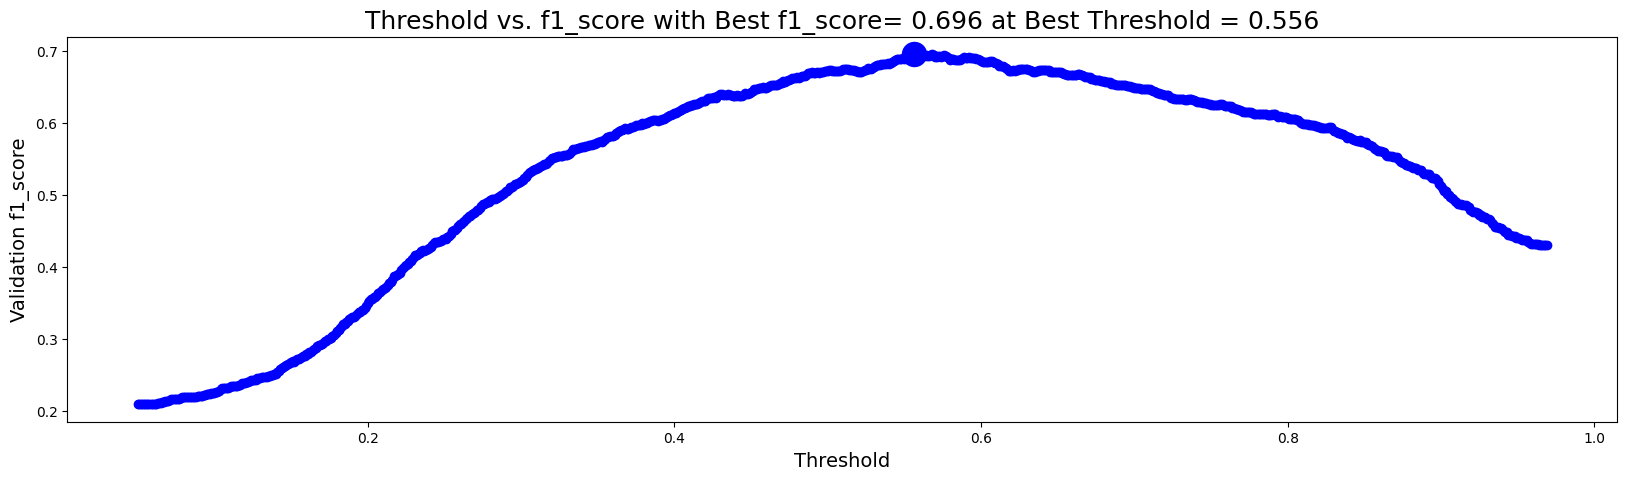

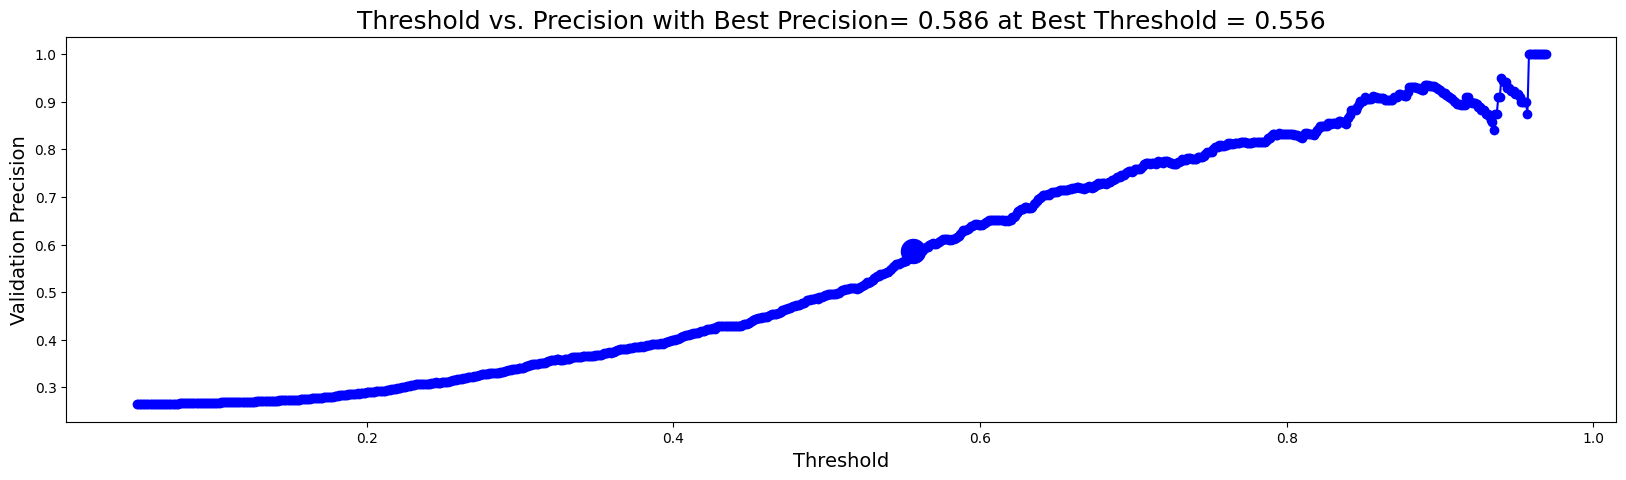

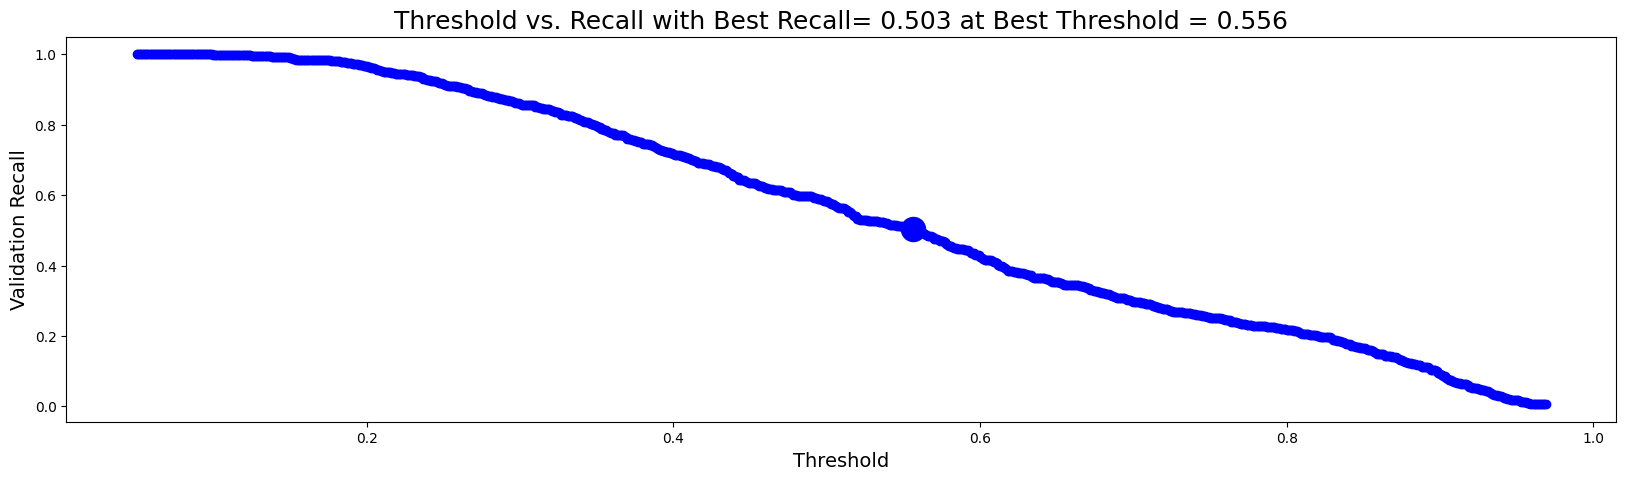

In [ ]:
scores_f1_score=[]
scores_Precision=[]
scores_Recall=[]
scores = []; thresholds = []
best_f1= 0;best_score_pr= 0;best_score_rc = 0; best_threshold = 0
true = y_train
for threshold in np.arange(0.05,0.97,0.001):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    # scores.append(m)
    pr = precision_score(true.values.reshape((-1)), preds)
    rc = recall_score(true.values.reshape((-1)), preds)
    f1 = f1_score(true.values.reshape((-1)), preds,average='macro')
    m= f1_score(true.values.reshape((-1)), preds,average='macro')
    scores_f1_score.append(f1)
    scores_Precision.append(pr)
    scores_Recall.append(rc)
    thresholds.append(threshold)
    if m>best_f1:
        best_f1 = m
        best_score_pr = pr
        best_score_rc = rc
        best_threshold = threshold
scores_dict = {
            'f1_score':[scores_f1_score,best_f1],
            'Precision':[scores_Precision,best_score_pr],
            'Recall':[scores_Recall,best_score_rc]}
for i in scores_dict.keys():
  plot(scores_dict[i][0],scores_dict[i][1],i)

In [ ]:
best_threshold

0.5560000000000005

In [ ]:
best_threshold_all +=best_threshold

In [ ]:
def f1_xgb(predt: np.ndarray, dtrain: xgb.DMatrix):
    """Used when there's no custom objective."""
    # No need to do transform, XGBoost handles it internally.
    y_true = dtrain.get_label()
    y_pred = (predt> 0.5).astype('int')
    # y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true.astype(int))
    f1 = f1_score(y_true, y_pred,average='macro')
    return 'f1', f1

### С весами XGB

In [ ]:
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=22)
indx_all = X_train.index
cv_scores_AUC_ROC = np.empty(N_SPLITS)
cv_scores_f1_score = np.empty(N_SPLITS)
cv_scores_Precision = np.empty(N_SPLITS)
cv_scores_Recall = np.empty(N_SPLITS)
cv_scores = np.empty(N_SPLITS)
roc_auc_score_1 = np.empty(N_SPLITS)
oof = pd.DataFrame(data=np.zeros((len(indx_all),1)), index=indx_all)
params = {'max_depth': 7,
        'gamma': 2,
        # 'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        # 'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : 0.6,
        'min_child_weight' : 4,
        'n_estimators': 1000,
        'seed': 42,
        'eta':0.05,
    }
# COMPUTE CV SCORE WITH 5 GROUP K FOLD
models_xgb=[]
for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):

    X_train_сv, X_val_сv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_сv, y_val_сv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    train_w0, train_w1 = calc_log_loss_weight(y_train_сv)
    valid_w0, valid_w1 = calc_log_loss_weight(y_val_сv)

    xgb_train = xgb.DMatrix(data=X_train_сv[columns], label=y_train_сv, weight=y_train_сv.map({0: train_w0, 1: train_w1}))
    xgb_valid = xgb.DMatrix(data=X_val_сv[columns], label=y_val_сv, weight=y_val_сv.map({0: valid_w0, 1: valid_w1}))

    # xgb_train = xgb.DMatrix(data=X_train_сv[columns], label=y_train_сv)
    # xgb_valid = xgb.DMatrix(data=X_val_сv[columns], label=y_val_сv)

    clf = xgb.train(
                params,
                dtrain = xgb_train,
                num_boost_round = 2000,
                evals = [(xgb_train, 'train'), (xgb_valid, 'eval')],
                early_stopping_rounds = 100,
                verbose_eval = 100,
                custom_metric = f1_xgb,
                # feval = xgb_metric,
                # maximize = CFG.metric_maximize_flag,
            )
    models_xgb.append(clf)

    y_pred = clf.predict(xgb.DMatrix(data=X_val_сv[columns]))
    y_pred_metki = (y_pred> 0.5).astype('int')
    oof.loc[X_val_сv.index,0] = y_pred
    precision = precision_score(y_val_сv, y_pred_metki)
    recall = recall_score(y_val_сv, y_pred_metki)
    cv_scores_AUC_ROC[idx] = roc_auc_score(y_val_сv, y_pred)
    cv_scores_f1_score[idx] = f1_score(y_val_сv, y_pred_metki,average='macro')
    cv_scores_Precision[idx] = precision
    cv_scores_Recall[idx] = recall

print("AUC_ROC----"+str(np.mean(cv_scores_AUC_ROC)))
print("F1-score-----"+str(np.mean(cv_scores_f1_score)))
print("Precision-----"+str(np.mean(cv_scores_Precision)))
print("Recall-----"+str(np.mean(cv_scores_Recall)))

[16:13:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:0.49231	train-f1:0.70586	eval-rmse:0.49666	eval-f1:0.61432
[99]	train-rmse:0.31663	train-f1:0.91993	eval-rmse:0.44734	eval-f1:0.68654
[16:13:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:0.49306	train-f1:0.68188	eval-rmse:0.49695	eval-f1:0.59034
[100]	train-rmse:0.30881	train-f1:0.92280	eval-rmse:0.45645	eval-f1:0.68802
[16:13:35] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:0.49296	train-f1:0.72047	eval-rmse:0.49671	eval-f1:0.62455
[100]	train-rmse:0.31142	train-f1:0.92940	eval-rmse:0.46501	eval-f1:0.67604
[101]	train-rmse:0.31142	train-f1:0.92940	eval-rmse:0.46501	eval-f1:0.67604
[16:13:40] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:0.49297	train-f1:0.70550	eval-rmse:0.49636	eval-f1:0.62037
[100]	train-rmse:0.31885	train-f1:0.92542

0.05, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.22, 0.22

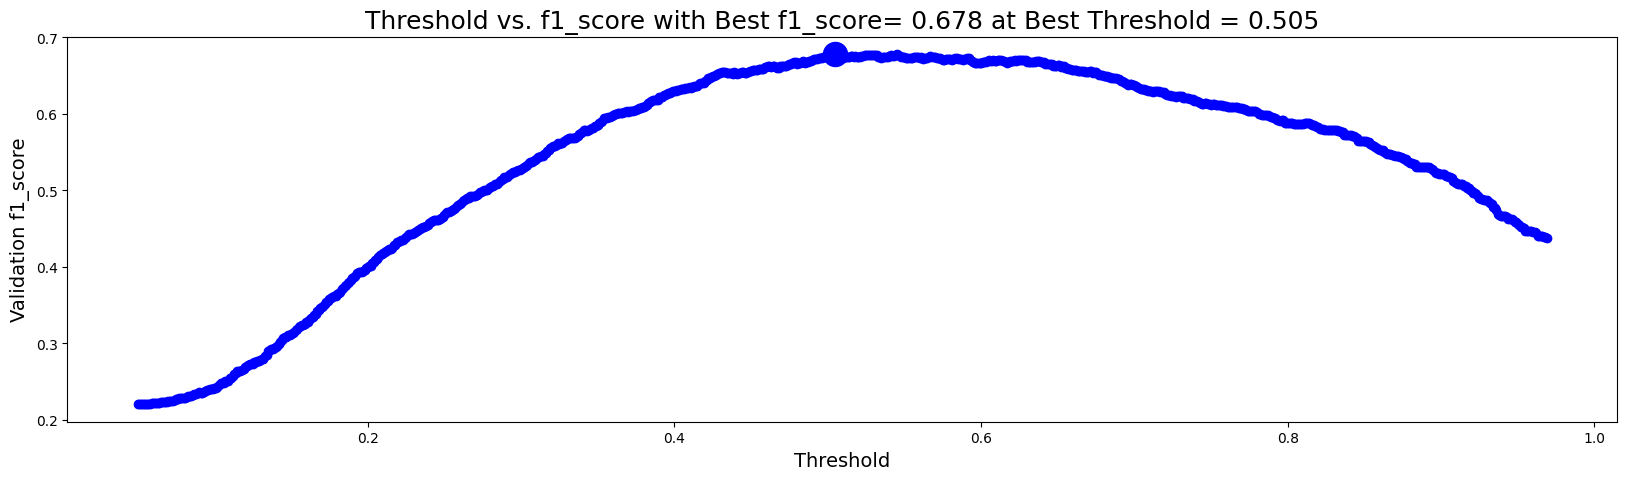

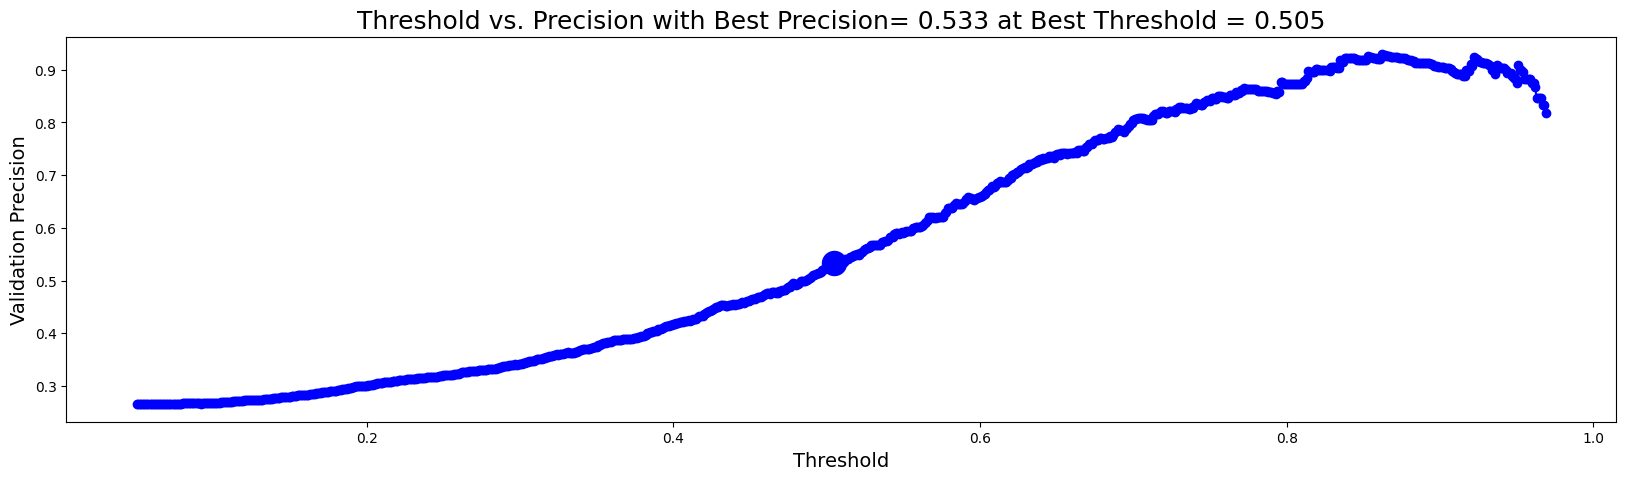

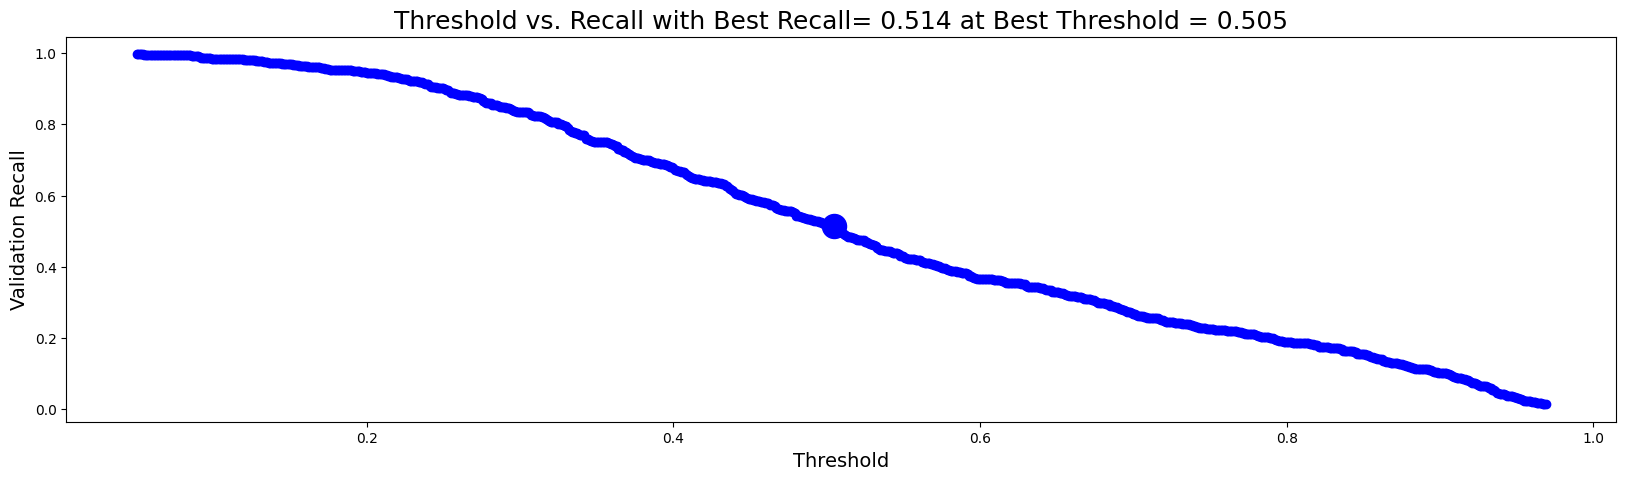

In [ ]:
scores_f1_score=[]
scores_Precision=[]
scores_Recall=[]
scores = []; thresholds = []
best_f1= 0;best_score_pr= 0;best_score_rc = 0; best_threshold = 0
true = y_train
for threshold in np.arange(0.05,0.97,0.001):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    # scores.append(m)
    pr = precision_score(true.values.reshape((-1)), preds)
    rc = recall_score(true.values.reshape((-1)), preds)
    f1 = f1_score(true.values.reshape((-1)), preds,average='macro')
    m= f1_score(true.values.reshape((-1)), preds,average='macro')
    scores_f1_score.append(f1)
    scores_Precision.append(pr)
    scores_Recall.append(rc)
    thresholds.append(threshold)
    if m>best_f1:
        best_f1 = m
        best_score_pr = pr
        best_score_rc = rc
        best_threshold = threshold
scores_dict = {
            'f1_score':[scores_f1_score,best_f1],
            'Precision':[scores_Precision,best_score_pr],
            'Recall':[scores_Recall,best_score_rc]}

for i in scores_dict.keys():
  plot(scores_dict[i][0],scores_dict[i][1],i)

In [ ]:
best_threshold_all += best_threshold

In [ ]:
def catboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for model in models_cat:
        # Predict
        test_pred += model.predict_proba(x_test)[:, 1]
    return test_pred / N_SPLITS

def lgbm_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for model in models_lgbm:
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / N_SPLITS
def xgboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for model in models_xgb:
        # Predict
        test_pred += model.predict(xgb.DMatrix(x_test[columns]))
        # test_pred += model.predict(xgb.DMatrix(x_test), iteration_range=(0, model.best_ntree_limit))
    return test_pred / N_SPLITS

In [ ]:
pred_cat = catboost_inference(X_test[columns])
pred_lgbm =lgbm_inference(X_test[columns])
pred_xgb = xgboost_inference(X_test[columns])

In [ ]:
test_preds = 0.8*pred_cat+0.1*pred_lgbm+0.1*pred_xgb

In [ ]:
best_threshold_all = best_threshold_all/3

In [ ]:
pred_marks = (test_preds> best_threshold).astype('int')

In [ ]:
print(precision_score(y_test, pred_marks))
print(recall_score(y_test,pred_marks))
print(f1_score(y_test, pred_marks,average='macro'))

0.5454545454545454
0.5818181818181818
0.699566730866635
